In [3]:
#import all relevant libraries
import cleaning as cl
import visualisation as vs
import models as mod
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Machine Leaning Project - Kickstarter
In this project, we analyze the kickstarter dataset and build several machine learning models. Our goal is to help an investor find a project to invest in. The investor is only interested in projects that are going to be successful.

## Import and data cleaning
First, we need to import the data. Then we remove duplicate entries.

In [4]:
#import data and safe it so the df_kick dataframe
df_kick = cl.read_data("data/")
#remove all duplicate entries
df_kick = cl.drop_duplicate(df_kick,"id")


Total number of entries: 209222
Number of unique entries: 182264
Number of rows that will be deleted: 26958


### Further data cleaning
We will drop the missing "blurb" entries, since this is important information we want to have. For now, we'll ignore the missing "location" values as this column might be redundant anyway.

Our analysis and research showed, that the "goal" is in the foreign currency. Since we want to compare all projects in USD, we transform "goal" to USD using the given "static_usd_rate". After that, we remove the now redundant columns

Possible states are live, successful, canceled, failed and suspended.
We drop live states, since they're not finished.
We also drop suspended states, as they are only 600 and we don't know exactly why they have been suspended.

We add canceled to failed, since for our use case the outcome is identical.

Since state is the feature we want to predict, we transform it into a 1/0 categorical variable.

All data cleaning is combined in the following function.

In [5]:
df_kick.reset_index()

,index,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,...,babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",28645.000000,international
1,1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,...,the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1950.000000,domestic
2,2,271,"Electra's long awaited, eclectic Debut Pop/Roc...","{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,...,record-electras-debut-album-pop-rock-classical,https://www.kickstarter.com/discover/categorie...,True,False,successful,1371013395,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",22404.000000,international
3,3,3,The Mist of Tribunal is a turn-based card game...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",165,GB,1483780271,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,£,...,the-mist-of-tribunal-a-card-game,https://www.kickstarter.com/discover/categorie...,False,False,failed,1489425776,1.216066,"{""web"":{""project"":""https://www.kickstarter.com...",165.384934,domestic
4,4,3,"Livng with a brain impairment, what its like t...","{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2820,US,1354817071,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,$,...,help-change-the-face-of-brain-impairment,https://www.kickstarter.com/discover/categorie...,True,False,successful,1357763527,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2820.000000,domestic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182259,209216,108,*PRE-SALES* for Our first Full-Length Album- c...,"{""id"":38,""name"":""Electronic Music"",""slug"":""mus...",4078,US,1405625585,"{""id"":356376150,""name"":""Pepper Proud"",""is_regi...",USD,$,...,it-springs-to-lifepellucidity-yaimas-first-album,https://www.kickstarter.com/discover/categorie...,True,False,successful,1412207040,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",4078.220000,domestic
182260,209218,72,"Soul, hip-hop and sexy falsettos with an opera...","{""id"":38,""name"":""Electronic Music"",""slug"":""mus...",5710,NL,1493041572,"{""id"":1412154830,""name"":""Lester Arias is ARIA ...",EUR,€,...,aria-lester-debut-ep,https://www.kickstarter.com/discover/categorie...,True,False,successful,1497909600,1.093300,"{""web"":{""project"":""https://www.kickstarter.com...",5575.830204,domestic
182261,209219,62,What started as a homemade gift has turned int...,"{""id"":52,""name"":""Hardware"",""slug"":""technology/...",2681,US,1341343795,"{""id"":891767476,""name"":""Doug Stienstra"",""is_re...",USD,$,...,flashpals-cuddly-usb-drives-save-more-than-you...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1347854341,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2681.000000,international
182262,209220,76,Seattle Transmedia & Independent Film Festival...,"{""id"":295,""name"":""Festivals"",""slug"":""film & vi...",5692,US,1425256957,"{""id"":307076473,""name"":""Timothy Vernor"",""is_re...",USD,$,...,transmedia-gallery-space-stiff-2015,https://www.kickstarter.com/discover/categorie...,True,False,successful,1429536379,1.000000,"{""web"":{""project"":""https://www.kick

In [6]:
df_kick = cl.clean_data(df_kick)

## Descriptive Statistics
Before building different models, we have a closer look at out data. We look at the distribution of our target feature, the state variable, to see how balanced out dataset is. In addition we look at a correlation matrix, some histograms and pairplots.

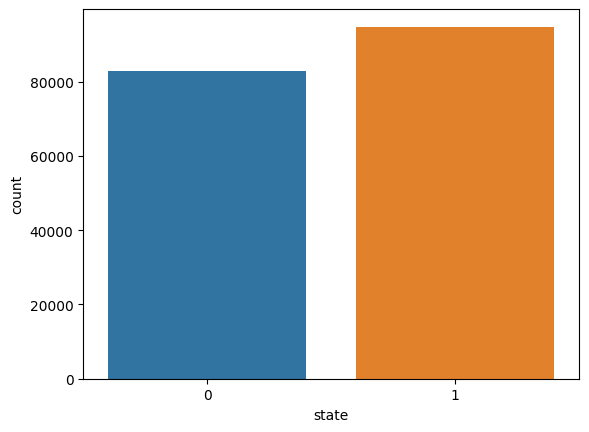

In [7]:
#check how balanced our dataset is
vs.countplot(df_kick, "state")

Out dataset is only slightly unbalaced with approx. 53% of the data being in state 1

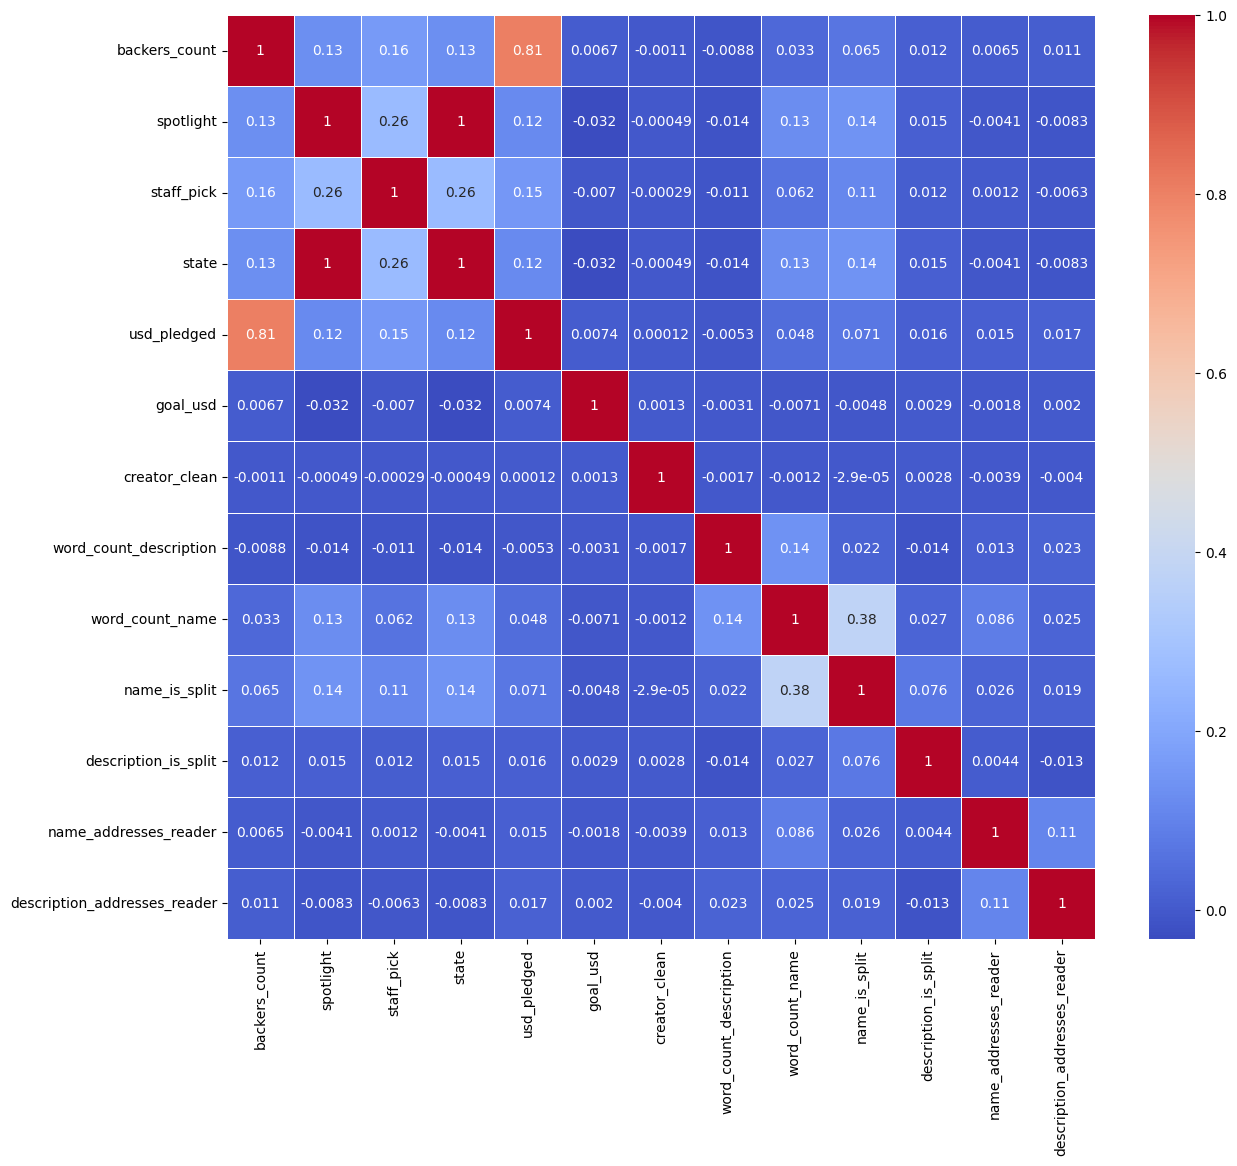

In [8]:
vs.corr_map(df_kick.drop("disable_communication",axis=1))

The features splotlight and state are 100% correlated. Hence, we drop spotlight.

In addition, usd_pledged and backers_count are highly correlated as well. This makes sense. However, we don't want to use these two features for our models since they are not known in advance.

In [9]:
df_kick = df_kick.drop("spotlight", axis=1) 

## Baseline Model
Our baseline model is to simply predict the positive outcome (state=successful) by the value of the goal in USD. As the threshold we choose the mean of all goal_usd values which is 5000$.

Baseline :
Accuracy: 0.5955854613024015
Recall: 0.5729222718112662
Precision: 0.6340241695370424


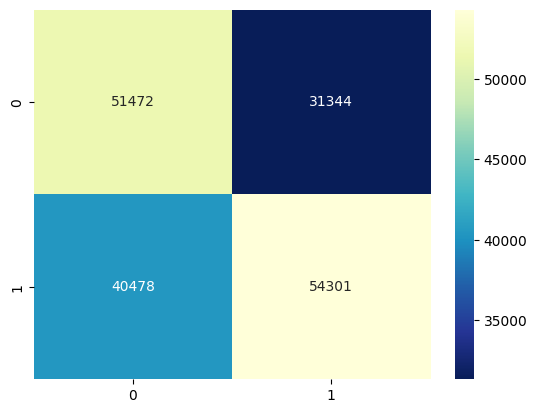

In [10]:
y_pred_baseline = mod.baseline(df_kick,"goal_usd",5000)
mod.eval_metrics(df_kick.state, y_pred_baseline, "Baseline")

So our very basic model is already better than randomly guessing. We chose precision as our main evaluation metric since our stakeholder in interested in accurate information about the probability of success. Our baseline model has a precision of 63%.

Now we try a model that is a little more complex, but still very simple. The model consists of a logistic regression with only one feature.

Logistic Regression :
Accuracy: 0.8271347729384273
Recall: 0.7546642774322757
Precision: 0.9060364464692483


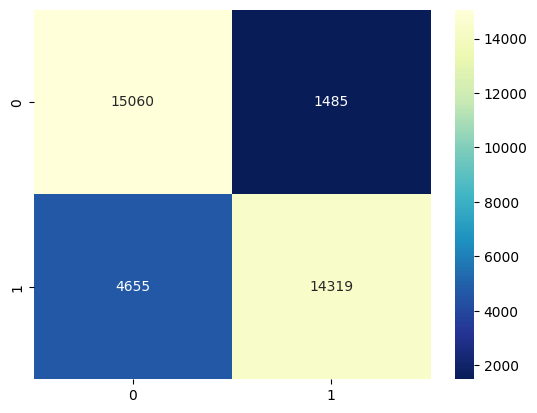

In [11]:
y = df_kick.state
X_simple = df_kick[["backers_count"]]
X_train_simple, X_test_simple, y_train, y_test = train_test_split(X_simple, y, test_size = 0.2, random_state = 0)

y_pred_simple = mod.simple_model(X_train_simple, y_train, X_test_simple)
mod.eval_metrics(y_test, y_pred_simple, "Logistic Regression")


The simple model based on backers_count has a precision of 91%. So backers_count is a very good predictor for the positive or negative outcome of the project. However, backers_count is not know in advance, so we do not use this feature for our models.

## Pipelines

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

In [13]:
df_kick.columns

Index(['backers_count', 'blurb', 'category', 'country', 'created_at',
       'creator', 'disable_communication', 'name', 'slug', 'staff_pick',
       'state', 'usd_pledged', 'goal_usd', 'category_clean', 'creator_clean',
       'word_count_description', 'word_count_name', 'name_is_split',
       'description_is_split', 'name_addresses_reader',
       'description_addresses_reader'],
      dtype='object')

In [14]:
df_kick.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177595 entries, 0 to 177602
Data columns (total 21 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   backers_count                 177595 non-null  int64         
 1   blurb                         177595 non-null  object        
 2   category                      177595 non-null  object        
 3   country                       177595 non-null  object        
 4   created_at                    177595 non-null  datetime64[ns]
 5   creator                       177595 non-null  object        
 6   disable_communication         177595 non-null  bool          
 7   name                          177595 non-null  object        
 8   slug                          177595 non-null  object        
 9   staff_pick                    177595 non-null  bool          
 10  state                         177595 non-null  int64         
 11  usd_pledged  

In [15]:
num_features = ["goal_usd"]
cat_features = ["category_clean", "country","staff_pick","word_count_description","word_count_name","name_is_split","description_is_split","name_addresses_reader","description_addresses_reader"] #creator_clean

In [16]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])
# Complete pipeline for numerical and categorical features
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [17]:
# Building a full pipeline with our preprocessor and a LogisticRegression Classifier
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])
# Building a full pipeline with our preprocessor and a DecisionTree Classifier
pipe_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier())
])
# Building a full pipeline with our preprocessor and a RandomForest Classifier
pipe_random_forest = Pipeline([
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestClassifier())
])

In [18]:
#choose our features & build train- and test-set
temp  = cat_features + num_features
X = df_kick[temp]
y = df_kick["state"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [19]:
param_logreg = {'logreg__penalty':('none','l1','l2'),
                'logreg__C': np.logspace(-2,5,10),
                'logreg__solver': ['liblinear', 'lbfgs', 'sag']
               }

rs_logreg = RandomizedSearchCV(pipe_logreg, param_logreg, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1, n_iter=10, random_state=17)

In [20]:
np.logspace(0,7,10)

array([1.00000000e+00, 5.99484250e+00, 3.59381366e+01, 2.15443469e+02,
       1.29154967e+03, 7.74263683e+03, 4.64158883e+04, 2.78255940e+05,
       1.66810054e+06, 1.00000000e+07])

In [21]:
param_tree = {'tree__criterion': ['gini', 'entropy'],
                'tree__splitter': ['best', 'random'],
                'tree__min_samples_split': range(1,300)
               }

rs_tree = RandomizedSearchCV(pipe_tree, param_tree, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1, n_iter=10, random_state=17)

In [22]:
# Defining parameter space for randomized search. 
param_random_forest = {'random_forest__n_estimators' : range(1,100),
            'random_forest__criterion': ['gini', 'entropy'],
            'random_forest__min_samples_leaf': range(1,100)
               }

rs_random_forest = RandomizedSearchCV(pipe_random_forest, param_random_forest, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1, n_iter=10, random_state = 7)

In [23]:
#rs_logreg.fit(X_train, y_train)

In [24]:
# Best score
#print('Best score:', round(rs_logreg.best_score_, 3))

# Best parameters
#print('Best parameters:', rs_logreg.best_params_)

Results:
|Best score|solver|penalty|C|
|---|---|---|---|
|0.694|lbfgs|none|2.15|

In [25]:
#rs_tree.fit(X_train, y_train)

In [26]:
# Best score
#print('Best score:', round(rs_tree.best_score_, 3))

# Best parameters
#print('Best parameters:', rs_tree.best_params_)

Results:
|Best score|splitter|min samples split|criterion|
|---|---|---|---|
|0.703|random|222|entropy|
|0.661|best|235|gini|

In [27]:
#rs_random_forest.fit(X_train, y_train)

In [28]:
# Best score
#print('Best score:', round(rs_random_forest.best_score_, 3))

# Best parameters
#print('Best parameters:', rs_random_forest.best_params_)

Results:
|Best score|n_estimators|min_samples_leaf|criterion|
|---|---|---|---|
|0.713|83|13|entropy|
|0.661|86|14|gini|

In [29]:
# Defining parameter space for grid search.
param_logreg = {'logreg__penalty':['none','l2'],
                'logreg__C': [1,1.5,2,2.5,3],
                'logreg__solver': ['liblinear', 'lbfgs']
               }

grid_logreg = GridSearchCV(pipe_logreg, param_grid=param_logreg, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)


param_tree = {'tree__criterion': ['entropy','gini'],
                'tree__splitter': ['random','best'],
                'tree__min_samples_split': range(220,240)
               }

grid_tree = GridSearchCV(pipe_tree, param_grid=param_tree, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)


param_random_forest = {'random_forest__n_estimators' : [80,85,90],
            'random_forest__criterion': ['gini','entropy'],
            'random_forest__min_samples_leaf': [13,14,15]
               }

grid_random_forest = GridSearchCV(pipe_random_forest, param_grid=param_random_forest, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)

In [30]:
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 4/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.3s
[CV 1/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.3s
[CV 5/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.3s
[CV 3/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.3s
[CV 2/5] END logreg__C=1, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=   0.3s
[CV 3/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   2.4s
[CV 2/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.6s
[CV 1/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=liblinear;, score=0.695 total time=   2.9s
[CV 4/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   3.1s
[C

/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END logreg__C=1, logreg__penalty=none, logreg__solver=lbfgs;, score=0.693 total time=  10.6s
[CV 4/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   3.9s
[CV 5/5] END logreg__C=1, logreg__penalty=none, logreg__solver=lbfgs;, score=0.691 total time=  10.3s
[CV 2/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   4.4s
[CV 3/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   4.4s


/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END logreg__C=1, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.690 total time=   4.5s
[CV 2/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.8s
[CV 3/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.692 total time=   2.4s
[CV 1/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.695 total time=   3.1s
[CV 5/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.691 total time=   2.2s
[CV 4/5] END logreg__C=1.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   5.8s
[CV 4/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.9s
[CV 2/5] END logreg__C=1.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   7.1s
[CV 1/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.695 total time=   4.3s
[CV 1/5] END logreg__C=2, logreg__penalty=none, logreg__solv

/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END logreg__C=1.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.691 total time=   9.5s


/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   4.4s
[CV 2/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   5.1s
[CV 3/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   4.9s


/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END logreg__C=1.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.693 total time=  11.1s
[CV 5/5] END logreg__C=1.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.691 total time=   4.6s
[CV 2/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.5s
[CV 1/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.696 total time=   2.8s
[CV 3/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   2.6s
[CV 2/5] END logreg__C=2, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   6.5s
[CV 4/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.5s
[CV 4/5] END logreg__C=2, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   5.6s
[CV 5/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=liblinear;, score=0.691 total time=   2.5s
[CV 1/5] END logreg__C=2, logreg__penalty=none, logreg__solver=lbfgs;,

/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END logreg__C=2, logreg__penalty=none, logreg__solver=lbfgs;, score=0.691 total time=   9.1s


/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END logreg__C=2, logreg__penalty=none, logreg__solver=lbfgs;, score=0.693 total time=  10.5s
[CV 2/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   4.4s


/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.691 total time=   5.1s
[CV 4/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   5.3s
[CV 3/5] END logreg__C=2, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   5.5s
[CV 2/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   2.8s
[CV 1/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.696 total time=   3.3s
[CV 3/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   3.1s
[CV 4/5] END logreg__C=2.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   7.1s
[CV 2/5] END logreg__C=2.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   8.6s
[CV 4/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   3.7s
[CV 5/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=libli

/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END logreg__C=2.5, logreg__penalty=none, logreg__solver=lbfgs;, score=0.693 total time=  12.3s


/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   5.0s
[CV 5/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.691 total time=   4.5s
[CV 2/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.694 total time=   6.0s


/Users/marvenhamm/neuefische/ds-kickstarter/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END logreg__C=2.5, logreg__penalty=l2, logreg__solver=lbfgs;, score=0.693 total time=   6.0s
[CV 2/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, score=0.694 total time=   3.3s
[CV 1/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, score=0.696 total time=   3.7s
[CV 3/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, score=0.692 total time=   2.9s
[CV 4/5] END logreg__C=3, logreg__penalty=none, logreg__solver=lbfgs;, score=0.694 total time=   7.1s
[CV 2/5] END logreg__C=3, logreg__penalty=none, logreg__solver=lbfgs;, score=0.695 total time=   8.1s
[CV 4/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, score=0.693 total time=   2.9s
[CV 5/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=liblinear;, score=0.690 total time=   3.2s
[CV 1/5] END logreg__C=3, logreg__penalty=none, logreg__solver=lbfgs;, score=0.696 total time=  10.8s
[CV 1/5] END logreg__C=3, logreg__penalty=l2, logreg__solver=lbfgs;, sco

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['goal_usd']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['category_clean',
                                                                          'country',
                                                      

In [31]:
grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.703 total time=   4.1s
[CV 3/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.696 total time=   4.4s
[CV 2/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.702 total time=   4.8s
[CV 5/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.703 total time=   4.4s
[CV 4/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=random;, score=0.703 total time=   4.9s
[CV 2/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=best;, score=0.701 total time=   5.2s
[CV 1/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=best;, score=0.703 total time=   5.6s
[CV 3/5] END tree__criterion=entropy, tree__min_samples_split=220, tree__splitter=best;,

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['goal_usd']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['category_clean',
                                                                          'country',
                                                      

In [32]:
grid_random_forest.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.717 total time=  32.8s
[CV 3/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.707 total time=  33.1s
[CV 2/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.712 total time=  33.5s
[CV 5/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.711 total time=  34.3s
[CV 1/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=85;, score=0.717 total time=  34.6s
[CV 4/5] END random_forest__criterion=gini, random_forest__min_samples_leaf=13, random_forest__n_estimators=80;, score=0.715 total time=  34.9s
[CV 3/5] END random_forest__criterion=gini, random_forest__min_samples_leaf

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['goal_usd']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['category_clean',
                                                                          'country',
                                                      

In [33]:
# Show best parameters
print('Best score logreg:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters logreg:\n{}".format(grid_logreg.best_params_))
print('Best score tree:\n{:.2f}'.format(grid_tree.best_score_))
print("Best parameters tree:\n{}".format(grid_tree.best_params_))
print('Best score random forest:\n{:.2f}'.format(grid_random_forest.best_score_))
print("Best parameters random forest:\n{}".format(grid_random_forest.best_params_))

Best score logreg:
0.69
Best parameters logreg:
{'logreg__C': 1, 'logreg__penalty': 'none', 'logreg__solver': 'lbfgs'}
Best score tree:
0.70
Best parameters tree:
{'tree__criterion': 'gini', 'tree__min_samples_split': 223, 'tree__splitter': 'random'}
Best score random forest:
0.71
Best parameters random forest:
{'random_forest__criterion': 'gini', 'random_forest__min_samples_leaf': 15, 'random_forest__n_estimators': 90}


In [34]:
# Save best model (including fitted preprocessing steps) as best_model 
best_model_logreg = grid_logreg.best_estimator_
best_model_tree = grid_tree.best_estimator_
best_model_random_forest = grid_random_forest.best_estimator_


In [35]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_train_predicted_logreg = best_model_logreg.predict(X_train)
y_train_predicted_tree = best_model_tree.predict(X_train)
y_train_predicted_random_forest = best_model_random_forest.predict(X_train)
y_test_predicted_logreg = best_model_logreg.predict(X_test)
y_test_predicted_tree = best_model_tree.predict(X_test)
y_test_predicted_random_forest = best_model_random_forest.predict(X_test)


In [36]:
mod.eval_metrics(y_train,y_train_predicted_logreg, "logistic regression - train", False)
mod.eval_metrics(y_test,y_test_predicted_logreg, "logistic regression - test", False)
mod.eval_metrics(y_train,y_train_predicted_tree, "decision tree - train", False)
mod.eval_metrics(y_test,y_test_predicted_tree, "decision tree - test", False)
mod.eval_metrics(y_train,y_train_predicted_random_forest, "random forest - train", False)
mod.eval_metrics(y_test,y_test_predicted_random_forest, "random forest - test", False)

logistic regression - train :
Accuracy: 0.6994425518736451
Recall: 0.7800408944001055
Precision: 0.6943599619535222
logistic regression - test :
Accuracy: 0.6973450829133703
Recall: 0.7801728681353431
Precision: 0.6923112898699841
decision tree - train :
Accuracy: 0.7209521664461275
Recall: 0.7673108633995119
Precision: 0.725506093073728
decision tree - test :
Accuracy: 0.6930093752639432
Recall: 0.7439654263729314
Precision: 0.7001289554607678
random forest - train :
Accuracy: 0.7270686111658549
Recall: 0.7932722115955412
Precision: 0.7224171071600192
random forest - test :
Accuracy: 0.7153636082096906
Recall: 0.785390534415516
Precision: 0.7116523400191022


In [37]:
#Max Voting
from sklearn.ensemble import VotingClassifier

model1 = best_model_logreg #LogisticRegression(random_state = 24)
model2 = best_model_tree # DecisionTreeClassifier(random_state = 24)
model3 = best_model_random_forest #RandomForestClassifier(random_state = 24)

model = VotingClassifier(estimators = [('lr', model1), ('dt', model2), ('rf', model3)], voting = 'hard')
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.711056054506039

In [38]:
y_test_predicted_voting = model.predict(X_test)
y_train_predicted_voting = model.predict(X_train)

In [39]:
mod.eval_metrics(y_train,y_train_predicted_voting, "voting - train", False)
mod.eval_metrics(y_test,y_test_predicted_voting, "voting - test", False)

voting - train :
Accuracy: 0.7230637123792899
Recall: 0.7852648242200383
Precision: 0.7207094860463709
voting - test :
Accuracy: 0.711056054506039
Recall: 0.7760619795509645
Precision: 0.7100149476831091


# Model Evaluation

In [40]:
#Imports
from sklearn.metrics import fbeta_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

## Logistic Regression

Logistic Regression on train data
fbeta score: 0.7613
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.61      0.65     66271
           1       0.69      0.78      0.73     75805

    accuracy                           0.70    142076
   macro avg       0.70      0.69      0.69    142076
weighted avg       0.70      0.70      0.70    142076

------------------------------------------------------------


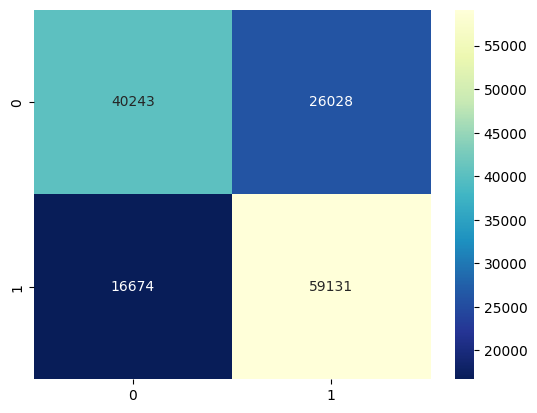

In [41]:
# Plot confusion matrix and classification report for best Logistic regression model

print("Logistic Regression on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_train, y_train_predicted_logreg, beta=2).round(4))
print("---"*20)
print(classification_report(y_train, y_train_predicted_logreg))
print("---"*20)

cm = confusion_matrix(y_train, y_train_predicted_logreg)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

Logistic Regression on test data
fbeta score: 0.7609
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.60      0.65     16545
           1       0.69      0.78      0.73     18974

    accuracy                           0.70     35519
   macro avg       0.70      0.69      0.69     35519
weighted avg       0.70      0.70      0.69     35519

------------------------------------------------------------


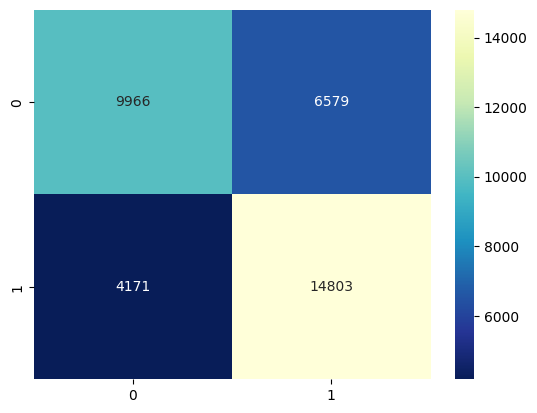

In [42]:
# Plot confusion matrix and classification report for best logreg model

print("Logistic Regression on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_predicted_logreg, beta=2).round(4))
print("---"*20)
print(classification_report(y_test, y_test_predicted_logreg))
print("---"*20)

cm = confusion_matrix(y_test, y_test_predicted_logreg)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

## Decision Tres

Decision Tree on train data
fbeta score: 0.7586
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.67      0.69     66271
           1       0.73      0.77      0.75     75805

    accuracy                           0.72    142076
   macro avg       0.72      0.72      0.72    142076
weighted avg       0.72      0.72      0.72    142076

------------------------------------------------------------


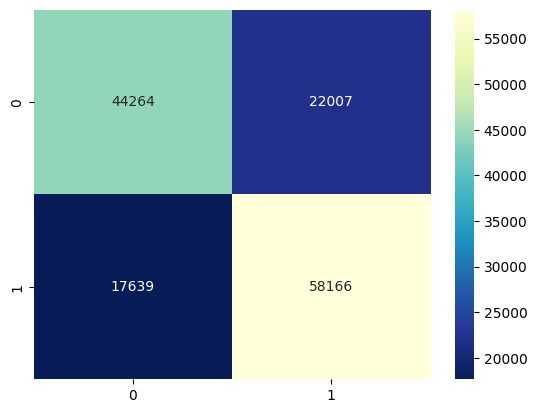

In [43]:
# Plot confusion matrix and classification report for best Tree model

print("Decision Tree on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_train, y_train_predicted_tree, beta=2).round(4))
print("---"*20)
print(classification_report(y_train, y_train_predicted_tree))
print("---"*20)

cm = confusion_matrix(y_train, y_train_predicted_tree)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");


Decision Tree on test data
fbeta score: 0.7348
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.68      0.63      0.66     16545
           1       0.70      0.74      0.72     18974

    accuracy                           0.69     35519
   macro avg       0.69      0.69      0.69     35519
weighted avg       0.69      0.69      0.69     35519

------------------------------------------------------------


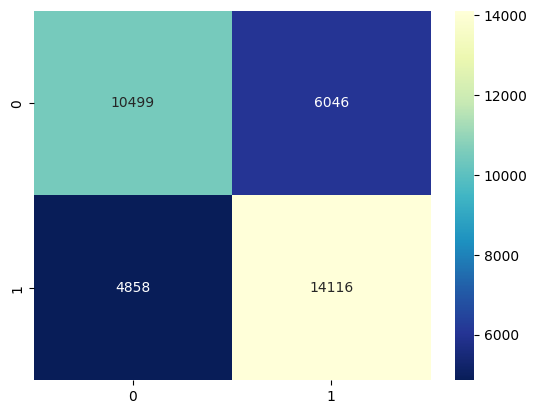

In [44]:
# Plot confusion matrix and classification report for best Tree model

print("Decision Tree on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_predicted_tree, beta=2).round(4))
print("---"*20)
print(classification_report(y_test, y_test_predicted_tree))
print("---"*20)

cm = confusion_matrix(y_test, y_test_predicted_tree)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

## Random Forest

Random Forest on test data
fbeta score: 0.7694
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.64      0.68     16545
           1       0.71      0.79      0.75     18974

    accuracy                           0.72     35519
   macro avg       0.72      0.71      0.71     35519
weighted avg       0.72      0.72      0.71     35519

------------------------------------------------------------


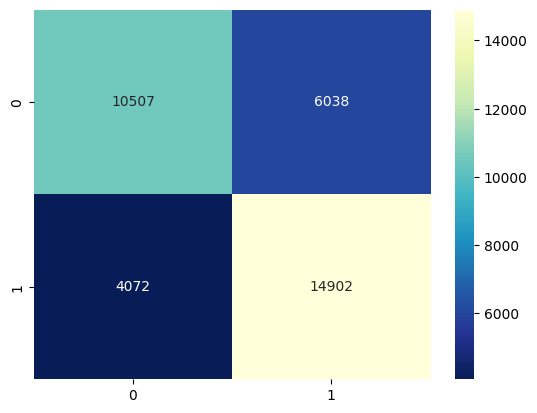

In [45]:
# Plot confusion matrix and classification report for best Random Forest model

print("Random Forest on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_predicted_random_forest, beta=2).round(4))
print("---"*20)
print(classification_report(y_test, y_test_predicted_random_forest))
print("---"*20)

cm = confusion_matrix(y_test, y_test_predicted_random_forest)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

Random Forest on test data
fbeta score: 0.7694
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.64      0.68     16545
           1       0.71      0.79      0.75     18974

    accuracy                           0.72     35519
   macro avg       0.72      0.71      0.71     35519
weighted avg       0.72      0.72      0.71     35519

------------------------------------------------------------


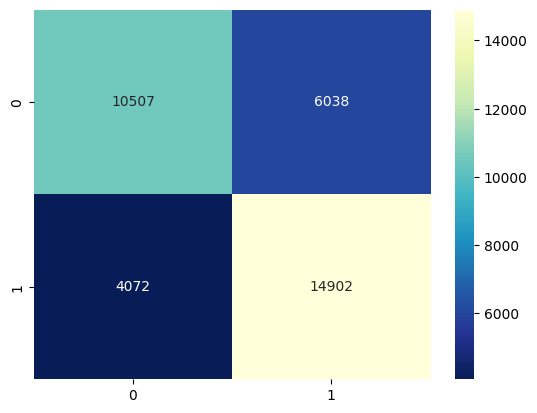

In [46]:
# Plot confusion matrix and classification report for best random forest model

print("Random Forest on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_predicted_random_forest, beta=2).round(4))
print("---"*20)
print(classification_report(y_test, y_test_predicted_random_forest))
print("---"*20)

cm = confusion_matrix(y_test, y_test_predicted_random_forest)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

# Error Analyisis

In [47]:
# Stratified train-test-split
df_train, df_test= train_test_split(df_kick, test_size=0.2, random_state=0)

In [48]:
correct = []
for pred, true in zip(y_test_predicted_logreg, y_test):
    if pred == true and pred==1:
        correct.append("TP")
    if pred == true and pred==0:
        correct.append("TN")
    if pred != true and pred==1:
        correct.append("FP")
    if pred != true and pred==0:
        correct.append("FN")

df_test["correct"] = correct
df_test.head()

,backers_count,blurb,category,country,created_at,creator,disable_communication,name,slug,staff_pick,...,goal_usd,category_clean,creator_clean,word_count_description,word_count_name,name_is_split,description_is_split,name_addresses_reader,description_addresses_reader,correct
155300,4,Open Mouvement is a place accessible to all pe...,"{""id"":256,""name"":""Spaces"",""slug"":""dance/spaces...",CH,2017-03-14 12:16:39,"{""id"":1136756747,""name"":""Open Mouvement"",""is_r...",False,Open Mouvement: a Dance School in a New Cultur...,open-mouvement-a-dance-school-in-a-new-cultura...,False,...,10380.734200,dance,1136756747,21,10,1,0,0,0,FP
175019,18,An app that strengthens relationships while yo...,"{""id"":332,""name"":""Apps"",""slug"":""technology/app...",US,2015-01-12 03:14:37,"{""id"":1326144502,""name"":""Michael Osofsky"",""is_...",False,Fun relationship app for Valentine's Day,fun-relationship-app-for-valentines-day,False,...,10.000000,technology,1326144502,11,6,0,0,0,0,FN
84986,0,"""Tell Me Why""\nOdel Is Looking To Finish His F...","{""id"":42,""name"":""Pop"",""slug"":""music/pop"",""posi...",US,2015-03-25 19:10:21,"{""id"":1824206714,""name"":""Odel Young"",""is_regis...",False,Tell Me Why,tell-me-why,False,...,2000.000000,music,1824206714,14,3,0,0,0,0,FP
145771,1,A project to send New York hip-hop artists to ...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-ho...",AU,2017-08-04 14:18:59,"{""id"":1541193398,""name"":""Knapsack"",""is_registe...",False,Australia - New York Hip-Hop Exchange,australia-new-york-hip-hop-exchange,False,...,16799.653842,music,1541193398,21,6,1,0,0,0,FP
75639,42,The human race is in a bit of a rut. After a m...,"{""id"":32,""name"":""Shorts"",""slug"":""film & video/...",US,2016-05-04 20:27:06,"{""id"":261151201,""name"":""Spencer Harris"",""is_re...",False,CURALL: A Short Film,curall-a-short-film,False,...,5000.000000,film & video,261151201,25,4,1,0,0,0,TP


In [49]:
# Limitations for ploting
df_plot = df_test.query("usd_pledged < 300000")
df_test = df_test.query("backers_count < 20000")
df_test = df_test.query("goal_usd < 200000")

df_test.head()

,backers_count,blurb,category,country,created_at,creator,disable_communication,name,slug,staff_pick,...,goal_usd,category_clean,creator_clean,word_count_description,word_count_name,name_is_split,description_is_split,name_addresses_reader,description_addresses_reader,correct
155300,4,Open Mouvement is a place accessible to all pe...,"{""id"":256,""name"":""Spaces"",""slug"":""dance/spaces...",CH,2017-03-14 12:16:39,"{""id"":1136756747,""name"":""Open Mouvement"",""is_r...",False,Open Mouvement: a Dance School in a New Cultur...,open-mouvement-a-dance-school-in-a-new-cultura...,False,...,10380.734200,dance,1136756747,21,10,1,0,0,0,FP
175019,18,An app that strengthens relationships while yo...,"{""id"":332,""name"":""Apps"",""slug"":""technology/app...",US,2015-01-12 03:14:37,"{""id"":1326144502,""name"":""Michael Osofsky"",""is_...",False,Fun relationship app for Valentine's Day,fun-relationship-app-for-valentines-day,False,...,10.000000,technology,1326144502,11,6,0,0,0,0,FN
84986,0,"""Tell Me Why""\nOdel Is Looking To Finish His F...","{""id"":42,""name"":""Pop"",""slug"":""music/pop"",""posi...",US,2015-03-25 19:10:21,"{""id"":1824206714,""name"":""Odel Young"",""is_regis...",False,Tell Me Why,tell-me-why,False,...,2000.000000,music,1824206714,14,3,0,0,0,0,FP
145771,1,A project to send New York hip-hop artists to ...,"{""id"":39,""name"":""Hip-Hop"",""slug"":""music/hip-ho...",AU,2017-08-04 14:18:59,"{""id"":1541193398,""name"":""Knapsack"",""is_registe...",False,Australia - New York Hip-Hop Exchange,australia-new-york-hip-hop-exchange,False,...,16799.653842,music,1541193398,21,6,1,0,0,0,FP
75639,42,The human race is in a bit of a rut. After a m...,"{""id"":32,""name"":""Shorts"",""slug"":""film & video/...",US,2016-05-04 20:27:06,"{""id"":261151201,""name"":""Spencer Harris"",""is_re...",False,CURALL: A Short Film,curall-a-short-film,False,...,5000.000000,film & video,261151201,25,4,1,0,0,0,TP


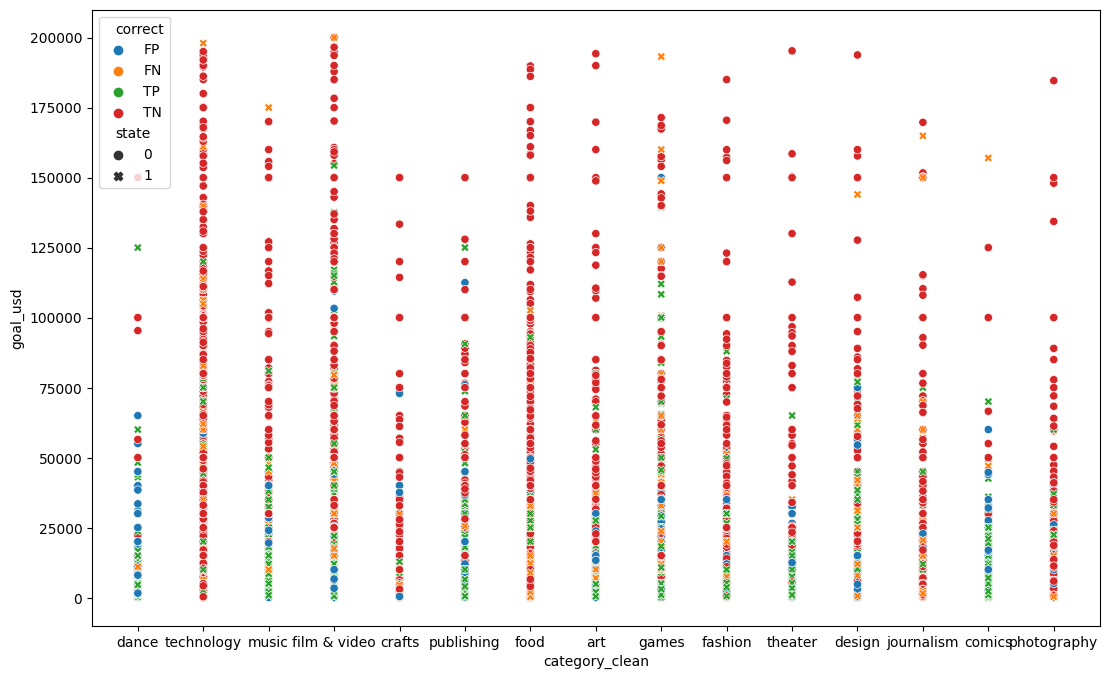

In [50]:
# Create exemplary scatterplot for two features
plt.subplots(figsize=(13,8))
sns.scatterplot(data=df_test, x="category_clean" , y="goal_usd", hue="correct", style= "state");